### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

### Load data

In [3]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH', 'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI', 'UMC','ANET','EPAM', 'UI','XM',
'GIB','TRMB', 'TYL','WIX','HPE','LYFT', 'LOGI', 'MPWR']
top10tech = top100tech[:10]

In [4]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [5]:
data = get_data_yf(top_energy, time_period)

[*********************100%***********************]  25 of 25 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

### Compute technical indicators

In [9]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Choose features

In [10]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

Feature correlations with predict_length

In [11]:
target = dataset['Close'].shift(predict_length)
dataset['Target'] = target
dataset

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI,Target
0,BP,2015-03-30,26.827076,26.941548,26.625065,26.625065,4272700.0,26.941548,26.625065,4.272700e+06,26.827076,NaN,-36.170023,0.316482,0.000000,0.000000,26.827076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
1,BP,2015-03-31,26.335522,26.564468,26.167179,26.247983,6200500.0,26.941548,26.167179,5.236600e+06,26.581299,0.347581,-57.627130,0.488190,-0.377080,-0.457886,26.563743,NaN,27.276462,25.886136,78.475043,74.475043,NaN,NaN,9.677803,-77.240462,-93.792715,9.677803,-1.832307,-0.008778,-27.552355,NaN
2,BP,2015-04-01,26.598135,26.712607,26.443260,26.517331,4285800.0,26.941548,26.167179,4.919667e+06,26.586911,0.245969,-42.499785,0.451155,0.148139,0.276081,26.576881,NaN,27.078849,26.094972,110.090375,106.090375,NaN,NaN,30.159364,32.835511,61.194305,19.918584,-0.853395,-0.004795,-1.622148,NaN
3,BP,2015-04-02,26.699135,26.773203,26.524057,26.557725,3501400.0,26.941548,26.167179,4.565100e+06,26.614967,0.208525,-29.728950,0.400653,0.060597,0.080797,26.614282,NaN,27.032016,26.197918,129.634711,125.634711,NaN,NaN,14.286606,15.124487,20.166350,18.041258,-0.476910,0.000023,7.174938,NaN
4,BP,2015-04-06,27.022358,27.157033,26.773209,26.833812,4656200.0,27.157033,26.167179,4.583320e+06,26.696445,0.256526,-35.087637,0.412102,0.383829,0.249152,26.720748,NaN,27.209496,26.183394,106.069345,102.069345,NaN,NaN,21.276660,93.139432,60.458847,18.850108,0.727929,0.012809,46.549525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37770,XOM,2021-03-23,55.220001,56.290001,54.450001,54.939999,33493300.0,62.549999,54.450001,3.757947e+07,59.199286,2.261015,-58.152153,1.843571,-0.570000,-1.450001,57.603377,60.066095,63.721317,54.677255,28.182610,24.182610,57.797500,46.473244,43.564399,-30.918235,-78.651734,83.610300,-2.300069,1.572926,-75.271690,59.110001
37771,XOM,2021-03-24,56.340000,57.279999,56.080002,56.080002,29781800.0,62.549999,54.450001,3.599756e+07,59.030000,2.385749,-78.333418,1.780000,0.989998,1.630001,57.434926,60.108762,63.801499,54.258502,26.742752,22.742752,58.117602,50.575459,24.427613,55.617870,91.573114,84.596351,-4.036789,1.383127,-43.778471,59.369999
37772,XOM,2021-03-25,56.180000,56.500000,54.500000,55.209999,31495900.0,62.549999,54.450001,3.457600e+07,58.690715,2.432066,-15.999985,1.755714,-0.779999,-1.580002,57.267603,59.810191,63.554847,53.826583,26.132041,22.132041,58.360357,49.986096,33.898426,-44.426304,-89.991989,86.162108,-7.795831,1.206962,-58.308264,56.810001
37773,XOM,2021-03-26,57.709999,57.779999,56.520000,57.299999,34205300.0,62.549999,54.450001,3.429479e+07,58.465000,2.359817,-5.555539,1.742142,1.279999,2.020000,57.326589,59.489524,63.184634,53.745367,26.775230,22.775230,58.541939,55.344932,22.424298,73.472689,115.949225,86.920213,-5.191391,1.152200,-24.766535,56.490002


In [25]:
close = dataset['Close']
indicate = dataset.columns[2:-1]
pearson_current_day = []
pearson_target = []
spearman_current_day = []
spearman_target = []
kendall_current_day = []
kendall_target = []

for i in indicate:
    pearson_current_day.append(close.corr(dataset[i]))
    pearson_target.append(target.corr(dataset[i]))
    spearman_current_day.append(close.corr(dataset[i], method='spearman'))
    spearman_target.append(target.corr(dataset[i], method='spearman'))
    kendall_current_day.append(close.corr(dataset[i], method='kendall'))
    kendall_target.append(target.corr(dataset[i], method='kendall'))
data_average_current_data = []
data_average_target_data = []
for i in range(len(indicate)):
    data_average_current = 0
    data_average_target = 0

    data_average_current += pearson_current_day[i] + spearman_current_day[i] + kendall_current_day[i]
    data_average_current /= 3
    data_average_current_data.append(data_average_current)

    data_average_target += pearson_target[i] + spearman_target[i] + kendall_target[i]
    data_average_target /= 3
    data_average_target_data.append(data_average_target)

indicators = {'Indicator':indicate}
data_pearson = {'Pearson Current Day':pearson_current_day,'Pearson Target':pearson_target}
data_spearman = {'Spearman Current Day':spearman_current_day,'Spearman Target':spearman_target}
data_kendall = {'Kendall Current Day':kendall_current_day,'Kendall Target':kendall_target}
data_average = {'Average Current Day':data_average_current_data,'Average Target':data_average_target_data}
df_indicator = pd.DataFrame(data=indicators)
df_pearson = pd.DataFrame(data=data_pearson)
df_spearman = pd.DataFrame(data=data_spearman)
df_kendall = pd.DataFrame(data=data_kendall)
df_average = pd.DataFrame(data=data_average)


In [27]:
df_aggregate = df_indicator.join(df_pearson)
df_aggregate = df_aggregate.join(df_spearman)
df_aggregate = df_aggregate.join(df_kendall)
df_aggregate = df_aggregate.join(df_average)
df_aggregate

,Indicator,Pearson Current Day,Pearson Target,Spearman Current Day,Spearman Target,Kendall Current Day,Kendall Target,Average Current Day,Average Target
0,Close,1.000000,0.993300,1.000000,0.994338,1.000000,0.954466,1.000000,0.980701
1,High,0.999796,0.993653,0.999822,0.994647,0.990743,0.956353,0.996787,0.981551
2,Low,0.999796,0.993324,0.999817,0.994294,0.990708,0.954927,0.996773,0.980848
3,Open,0.999612,0.993754,0.999690,0.994709,0.986211,0.957014,0.995171,0.981826
4,Volume,-0.246983,-0.242452,-0.255358,-0.252367,-0.174247,-0.172105,-0.225529,-0.222308
5,HH,0.995263,0.993793,0.995344,0.994420,0.955469,0.960065,0.982025,0.982759
6,LL,0.996078,0.993412,0.996171,0.994233,0.954639,0.957409,0.982296,0.981685
7,AV,-0.277209,-0.275904,-0.273754,-0.273429,-0.187630,-0.187338,-0.246198,-0.245557
8,SMA,0.997151,0.995741,0.997274,0.996533,0.960959,0.974797,0.985128,0.989024
9,SD,0.565990,0.573265,0.657591,0.658207,0.473144,0.473328,0.565575,0.568266


### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

### Train test split

In [13]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

#### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [14]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\c

c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\c

c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\c

#### Prepare training inputs and outputs
Convert the daily data points into a set of data points each with {trail_size} days.   
We keep track of the tickers so we can later inverse the normalization with the right model. 

In [15]:
x_train, y_train, tickers_train = roll_all_stocks(train, trail_size, predict_length)
x_valid, y_valid, tickers_valid = roll_all_stocks(valid, trail_size, predict_length)
x_test, y_test, tickers_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [16]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (17625, 14, 29)
y_train: (17625,)
x_valid: (5600, 14, 29)
y_valid (5600,)
x_test: (5825, 14, 29)
y_test (5825,)


In [17]:
print("tickers_train: {}".format(tickers_train.shape))
print("tickers_train: {}".format(tickers_valid.shape))
print("tickers_train: {}".format(tickers_test.shape))

tickers_train: (17625,)
tickers_train: (5600,)
tickers_train: (5825,)


### Model design

In [18]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            31500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [20]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train on many stocks

In [22]:
history1 = model.fit(x_train, y_train, epochs=45, validation_data=(x_valid, y_valid), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/45
276/276 [==============================] - 13s 27ms/step - loss: 0.0288 - val_loss: 0.0613
Epoch 2/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0134 - val_loss: 0.0469
Epoch 3/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0122 - val_loss: 0.0397
Epoch 4/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0119 - val_loss: 0.0331
Epoch 5/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0109 - val_loss: 0.0358
Epoch 6/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0092 - val_loss: 0.0302
Epoch 7/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0082 - val_loss: 0.0318
Epoch 8/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0081 - val_loss: 0.0312
Epoch 9/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0072 - val_loss: 0.0316
Epoch 10/45
276/276 [==============================] - 4s 15ms/step - loss: 0.0073 - val_l

### Prepare data for one stock

In [23]:
target_stock = 'XOM'

In [24]:
single_stock_dataset = dataset[dataset['Ticker']==target_stock].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

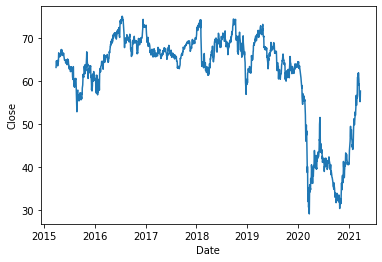

In [25]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

### Train test split

In [26]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2018-03-01"]
valid = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2018-03-13") & (single_stock_dataset['Date'] < "2019-03-01")]
test = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2019-03-01") & (single_stock_dataset['Date'] < "2020-03-01")]

In [27]:
single_stock_scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\pandas\c

#### Prepare training inputs and outputs
Since we are using just one stock, we don't need to keep track of tickers

In [28]:
x_train, y_train, _ = roll_all_stocks(train, trail_size, predict_length)
x_valid, y_valid, _ = roll_all_stocks(valid, trail_size, predict_length)
x_test, y_test, _ = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [29]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (705, 14, 29)
y_train: (705,)
x_valid: (224, 14, 29)
y_valid (224,)
x_test: (233, 14, 29)
y_test (233,)


### Test model on single stock

In [30]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Training RMSE = 1.5812294990970166


In [31]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict(x_valid), 
                                                      y_valid,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Validation RMSE = 2.2979109267493696


In [32]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features,
                                                    single_stock_scaler_models[target_stock])))

Testing RMSE = 2.119434252051266


In [33]:
model.layers[7].trainable = False
model.layers[4].trainable = False
model.layers[2].trainable = False
model.layers[0].trainable = False

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            31500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model on single stock

In [36]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [37]:
history2 = model.fit(x_train, y_train, epochs=45, validation_data=(x_valid, y_valid), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/45
12/12 [==============================] - 11s 612ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 2/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 3/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 4/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 5/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 6/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 7/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 8/45
12/12 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 9/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 10/45
12/12 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 11

### Visualize results

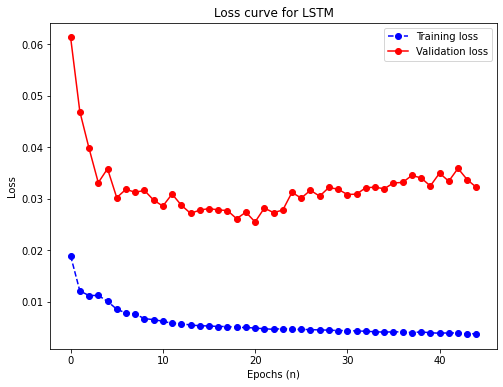

In [45]:
plot_loss(history1)

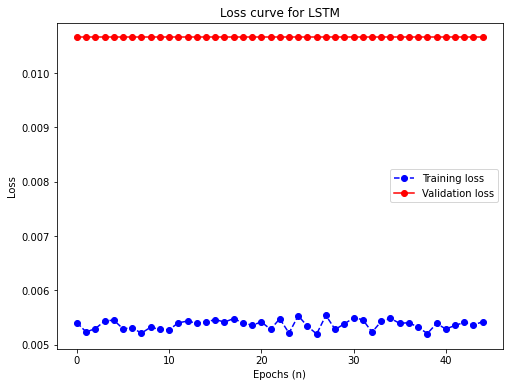

In [46]:
plot_loss(history2)

In [ ]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

In [ ]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict(x_valid), 
                                                      y_valid,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

In [ ]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features,
                                                    single_stock_scaler_models[target_stock])))

#### Compare to simple baseline

In [ ]:
def predict_no_change(x):
    return x[-1][0]

In [ ]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [ ]:
evaluate_model_rmse(no_change_preds, y_train, num_features, single_stock_scaler_models['XOM'])

In [ ]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [ ]:
evaluate_model_rmse(no_change_preds, y_test, num_features, single_stock_scaler_models['XOM'])

### Plot data against predictions

<AxesSubplot:title={'center':'Training performance'}>

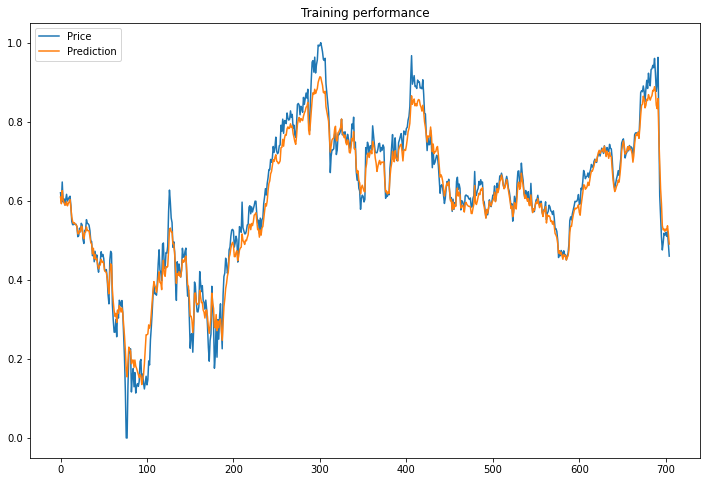

In [81]:
price_vs_preds = pd.DataFrame([x_train[:, -1, 0], model.predict(x_train)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Training performance")

<AxesSubplot:title={'center':'Validation performance'}>

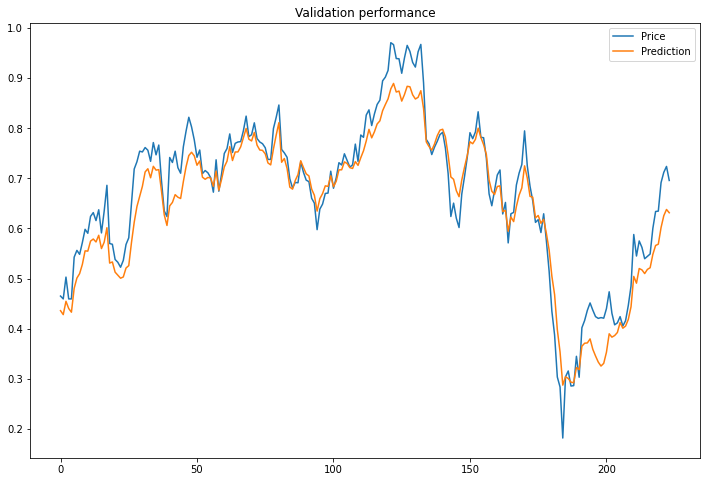

In [83]:
price_vs_preds = pd.DataFrame([x_valid[:, -1, 0], model.predict(x_valid)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Validation performance")

<AxesSubplot:title={'center':'Testing performance'}>

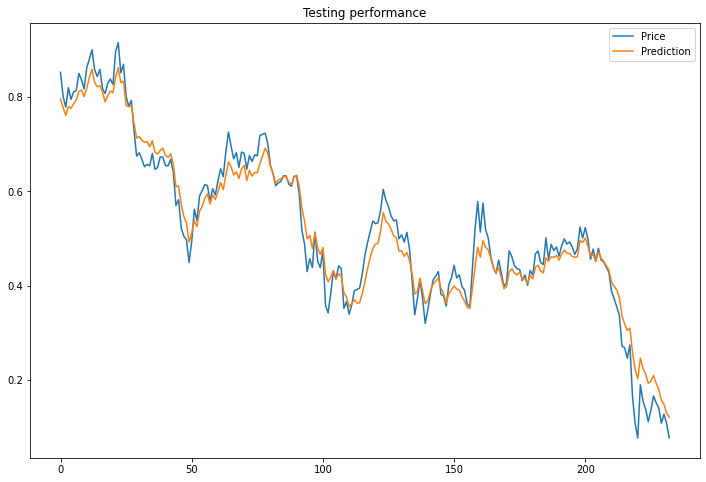

In [84]:
price_vs_preds = pd.DataFrame([x_test[:, -1, 0], model.predict(x_test)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Testing performance")